In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Cargar estados

In [2]:
## Lista con nombre de los estados
# estados = []
# ruta = '../datasets/raw/Google Maps/reviews-estados'
# for estado in os.listdir(ruta):
#         estado_path = os.path.join(ruta, estado)
        
#         if os.path.isdir(estado_path) and estado.startswith('review-'):
#             nombre_estado = estado[len('review-'):]
#             estados.append(nombre_estado)

In [3]:
# # Funcion para leer todos los json de una carpeta y unirlos en un datafram
# def read_all_json(folder_ruth):
#     dataframes = []
#     for archivo_json in os.listdir(folder_ruth):
#         if archivo_json.endswith('.json'):
#             # Construye la ruta completa del archivo JSON
#             ruta_archivo_json = os.path.join(folder_ruth, archivo_json)
            
#             # Lee el archivo JSON en un DataFrame
#             df = pd.read_json(ruta_archivo_json,lines=True)
            
#             # Agrega el DataFrame a la lista
#             dataframes.append(df)

#     # Concatena todos los DataFrames en uno solo
#     return pd.concat(dataframes, ignore_index=True)

In [4]:
# # Extraer la fecha del diccionario
# def extraer_resp_time(diccionario):
#     if diccionario is not None:
#         return diccionario['time']
#     else:
#         return None

# # Función para extraer 'resp_text'
# def extraer_resp_text(diccionario):
#     if diccionario is not None:
#         return diccionario['text']
#     else:
#         return None
    
# #Transformo los formatos de time, extraigo time y texto de respuesta
# def format_time(df):
#     df['time'] =  pd.to_datetime(df['time'], unit='ms')
#     df['resp_time'] = df['resp'].apply(extraer_resp_time)
#     df['resp_time'] = pd.to_datetime(df['resp_time'], unit='ms')
#     df['resp_text'] = df['resp'].apply(extraer_resp_text)
#     df['resp_text'] = df['resp'].apply(extraer_resp_text)
#     df.drop(columns=['resp'],inplace=True)

In [5]:
# for estado in estados:
#     rutas = f'{ruta}/review-{estado}'
#     df = read_all_json(rutas)
#     format_time(df)
#     df.to_parquet(f'./{rutas}/all_{estado}.parquet',index=False)

## Reviews

In [6]:
ruta ='../datasets/extras/Google Maps/reviews-estados'

In [7]:
metadata_google = pd.read_json('../datasets/extras/Google Maps/bussiness_google.json.gz', compression='gzip')


## Carga de datos por criterio

### Criterio: Lugar

In [8]:
# Discriminar por estado
estados = ['California', 'New_Jersey', 'Florida', 'Illinois'] 

df_states = pd.DataFrame()

for estado in estados:
    ruta_archivo = f'{ruta}/review-{estado}/all_{estado}.parquet'
    review_estado = pd.read_parquet(ruta_archivo)

    # Agrega la columna 'state' con el valor del estado actual
    review_estado['state'] = estado

    df_states = pd.concat([df_states, review_estado], ignore_index=True)
    
# df_states ahora contiene la concatenación de todos los DataFrames de los diferentes estados, con la columna 'state' agregada


Normalizo un estado

In [9]:
df_states['state'].replace('New_Jersey','New Jersey',inplace=True)

In [11]:
# Elimino duplicados en user_id time y gmap_id en conjunto
df_states.drop_duplicates(subset=['user_id','time','gmap_id'],inplace=True)

In [12]:
# Elimino la columna pics que no sera usada
df_states.drop(columns='pics',inplace=True)


### Criterio: Tiempo

In [ ]:
# Convertir la columna 'time' a tipo datetime
df_states['time'] = pd.to_datetime(df_states['time'])

# Filtrar los datos por año desde 2015 inclusive en adelante
df_states = df_states[df_states['time'].dt.year >= 2015]

# Eliminar las milésimas de segundo de la columna 'time'
df_states['time'] = df_states['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Filtrar los datos por año desde 2015 inclusive en adelante
df_states = df_states[df_states['resp_time'].dt.year >= 2015]

# Eliminar las milésimas de segundo de la columna 'time'
df_states['resp_time'] = df_states['resp_time'].dt.strftime('%Y-%m-%d %H:%M:%S')

In [15]:
# Renombrar columna de tiempo de respuesta
df_states.rename(columns={'resp_time':'resp_date'},inplace=True)
df_states.rename(columns={'stars':'rating'},inplace=True)

### Criterio: Rubro

In [16]:
metadata_google[['gmap_id','category']].head(1)

,gmap_id,category
4,0x88db4147b1d9e6f3:0x943dbd10a92ba1b1,['Restaurant']
5,0x88c2e4e34f1ed783:0x76c5da381c499d79,['Buffet restaurant']
46,0x8890b9241e704667:0x3a1e565c17c00993,['Restaurant']
81,0x88e635378f43352f:0xa1b53c63436fa428,['Gas station' 'ATM' 'Convenience store' 'Rest...
156,0x88d9ab98b5baad79:0x1a2e3f0642a55246,['Mexican restaurant']
...,...,...
693466,0x89c3b2b8e9c8c357:0xb1b07826ef85a598,['Bar' 'Italian restaurant' 'Pub' 'Restaurant']
693471,0x89c24d60acc3ffff:0xc8048546518281f6,['Restaurant' 'Family restaurant']
693475,0x89c24d7a198a3541:0x3dcb8f429c053248,['American restaurant']
693478,0x89c3b290dcc12d6d:0x34ad59938efed577,['Latin American restaurant' 'Mexican restaura...


Encuentro las review que por gmap_id pertenezcan a los locales de restaurante.

In [17]:
df_states = df_states[df_states['gmap_id'].isin(metadata_google['gmap_id'])]

## Analisis de sentimiento usando TextBlob

In [18]:
from textblob import TextBlob

In [19]:
df_states['sentiment_textblob'] = df_states['text'].apply(lambda x:0 if x is None else TextBlob(x).sentiment.polarity)
df_states['sentiment_textblob_resp'] = df_states['resp_text'].apply(lambda x:0 if x is None else TextBlob(x).sentiment.polarity)

Exploro y comparo ratings con score del sentimiento

In [20]:
df_states[df_states['sentiment_textblob']<0].sample(1)

,user_id,name,time,rating,text,gmap_id,resp_date,resp_text,state,sentiment_textblob,sentiment_textblob_resp
7717942,1.126497e+20,Pat Thompson,2020-06-27 18:24:54.709,1,Very slow,0x880c7389ae2404c5:0x4589781db842a1e1,2020-07-03 04:56:20.616999936,"Ouch, so sorry! We didn’t build the biz this w...",Illinois,-0.390000,-0.247768
5671330,1.022309e+20,Sol Ivette Cabrera,2018-06-10 18:22:58.812,2,Bad,0x88c2e48f2e525a21:0xe915850e0b764fa0,NaT,None,Florida,-0.700000,0.000000
3554082,1.085843e+20,Sebas Tangarife (Tanga),2021-03-30 09:13:39.645,1,"I really don't like the food. Creless chefs, ...",0x89c30a8f865a2c01:0xd7861df217e0bab9,NaT,None,New Jersey,-0.200000,0.000000
5282587,1.119970e+20,Mitchell Sweetz,2018-07-10 07:53:18.762,1,"The ""system [was] down"" indefinitely so I coul...",0x88d9290dc2a43deb:0xa36db6cff89a621c,NaT,None,Florida,-0.155556,0.000000
6147976,1.169251e+20,A Gooogle User,2019-08-26 17:32:53.360,1,Horrible customer service..owner is rude and u...,0x88e0a9bb63305873:0xc55048a8acf3c4f8,NaT,None,Florida,-0.040000,0.000000


### Criterio de sentiment

Voy a generar el criterio que en el sentimiento se obtenga un valor cuantificable mas real, normalizando el ranting y sumandole al socre

In [21]:
df_states['sentiment'] = df_states['rating'] / 5. + df_states['sentiment_textblob']

### En base al valor obtenido defino el criterio para score ponderado <br>
 mayor a 1.5 en un sentimiento muy bueno y asigno 2, <br>
 mayor a 1 y menor a 1.5 en un sentimiento bueno y asigno 1,<br>
 menor a 0.3 es un score negativo y asigno -1,<br>
 entre 1 y 0.3 es un score neutro y asigno 0

In [22]:
df_states['sentiment'] = df_states['sentiment'].apply(lambda x: 2 if x >= 1.5 else (1 if x >= 1 else (-1 if x <= 0.3 else 0)))

In [23]:
# Elimino las columnas que ya no se usan debido al analisis de sentimiento
df_states.drop(columns=['sentiment_textblob','text','resp_text', 'state'],inplace=True)

In [29]:
# Crear la columna 'review_id'
df_states['review_id'] = range(len(df_states))

C:\Users\bruno\AppData\Local\Temp\ipykernel_2044\3925477376.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_states.rename(columns=({


In [24]:
# Normalización de nombres de columnas
df_states.rename(columns={'resp_date': 'resp_date'}, inplace=True)
df_states.rename(columns={'sentiment_textblob_resp': 'resp_sentiment'}, inplace=True)
df_states.rename(columns={'time': 'date'}, inplace=True)
df_states.rename(columns={'rating': 'stars'}, inplace=True)
df_states = df_states[['review_id', 'user_id', 'gmap_id', 'stars', 'sentiment', 'date', 'resp_sentiment', 'resp_date']]
df_states.reset_index(inplace=True)
df_states.drop(columns = ['index'], inplace= True)
df_states.head(1)

,user_id,gmap_id,stars,sentiment,date,resp_sentiment,resp_date
0,1.089912e+20,0x80c2c778e3b73d33:0xbdc58662a4a97d49,5,2,2021-01-06 05:12:07.056,0.0,NaT
1,1.112903e+20,0x80c2c778e3b73d33:0xbdc58662a4a97d49,5,2,2021-02-09 05:47:28.663,0.0,NaT
2,1.126404e+20,0x80c2c778e3b73d33:0xbdc58662a4a97d49,4,0,2020-03-08 05:04:42.296,0.0,NaT
3,1.174403e+20,0x80c2c778e3b73d33:0xbdc58662a4a97d49,5,2,2019-03-07 05:56:56.355,0.0,NaT
4,1.005808e+20,0x80c2c778e3b73d33:0xbdc58662a4a97d49,5,2,2017-05-16 05:01:41.933,0.0,NaT
...,...,...,...,...,...,...,...
2452767,1.091054e+20,0x880fce33edd16c7b:0x44e066027b82ad8d,4,0,2016-09-01 01:03:33.962,0.0,NaT
2452768,1.159805e+20,0x880fce33edd16c7b:0x44e066027b82ad8d,4,0,2017-07-26 19:09:52.414,0.0,NaT
2452769,1.159471e+20,0x880fce33edd16c7b:0x44e066027b82ad8d,4,0,2015-11-16 17:06:38.468,0.0,NaT
2452770,1.179236e+20,0x880fce33edd16c7b:0x44e066027b82ad8d,3,0,2016-10-06 10:41:33.492,0.0,NaT


### Por último exporto el dataset a parquet particionado por estados

In [33]:
df_states.to_parquet('../datasets/processed/google/reviews_google.parquet.gz', compression='gzip')

---

## Analisis por año de las reviews

In [1]:
import pandas as pd

df = pd.read_parquet('../datasets/processed/google/reviews_google.parquet.gz')

C:\Users\Damian\AppData\Local\Temp\ipykernel_2836\3926654814.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(df['time'].dt.year.value_counts(), palette='deep')


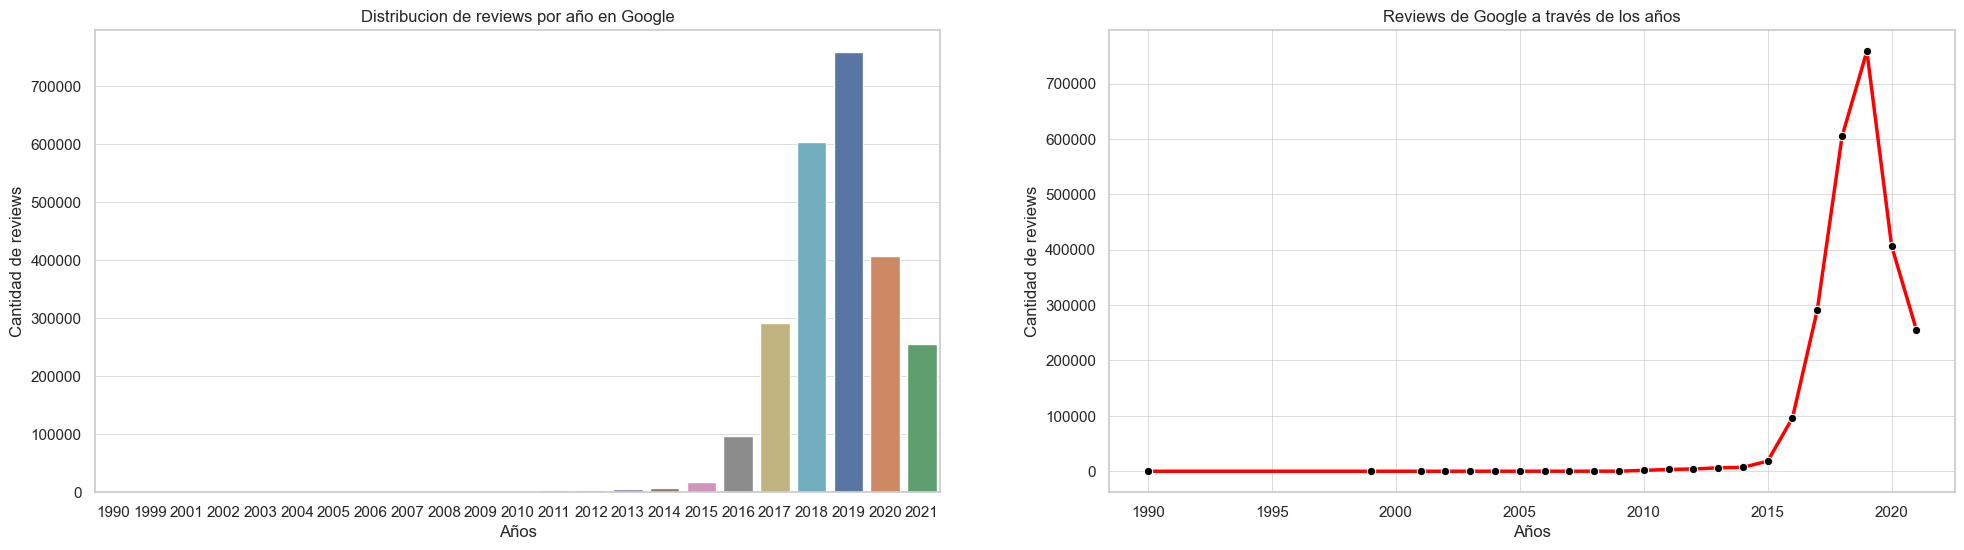

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(24,6))
plt.subplot(1,2,1)
plt.title('Distribucion de reviews por año en Google')
plt.ylabel('Cantidad de reviews')
plt.xlabel('Años')
sns.barplot(df['time'].dt.year.value_counts(), palette='deep')

plt.subplot(1,2,2)
plt.title('Reviews de Google a través de los años')
plt.ylabel('Cantidad de reviews')
plt.xlabel('Años')
# plt.xticks(list(range(2005,2023)))
sns.set(style="whitegrid",  rc={"grid.linewidth": 0.7, "grid.alpha": 0.7})
sns.lineplot(df['time'].dt.year.value_counts(), marker='o', markerfacecolor='black', color='red', linestyle='solid', linewidth=2.5).set_axisbelow(True)


plt.show()